## Modeling for predicting 72h ED revisit at ED disposition

Flow:
1. task-specific filter: exclude ED death cases for train and test
2. variable selection
3. Modeling script
4. Performance output


### Load train and test

In [1]:
import pandas as pd
import os
from helpers import PlotROCCurve
from sklearn.preprocessing import LabelEncoder
import time

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
#path = '/home/jun/data/MIMIC/mimiciv/1.0/processed'
path = '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark'

df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 0.95


In [2]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 
df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS,score_SERP2d,score_SERP7d,score_SERP30d
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,2,4,3,1,1,1,16,21,16
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,7,9,8,1,0,1,28,33,29
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,0,12,4,4,4,4,18,20,17
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,12,16,7,5,3,3,36,36,31
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,...,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0,87.000000,11,9,6,0,0,0,32,36,31


In [3]:
#revise time range + function name

### 1. task-specific filter: exclude ED death cases for train and test

In [4]:
df_train = df_train[(df_train['before_ed_mortality'] == False) & (df_train['outcome_hospitalization'] == False) & (df_train['ed_death'] == False)]
df_test = df_test[(df_test['before_ed_mortality'] == False) & (df_test['outcome_hospitalization'] == False) & (df_test['ed_death'] == False)]

### 2. Variable Selection

In [5]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]

outcome = "outcome_ed_revisit_3d"

In [6]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [7]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_los,n_med,n_medrecon
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,float64,float64


In [8]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [9]:
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60

In [10]:
print('class ratio')
print('positive : negative =', y_train.sum()/(~y_train).sum(), ': 1')

class ratio
positive : negative = 0.047332185886402756 : 1


### 3.  Modeling script

In [11]:
# Containers for all results
result_list = []

Logistic Regression:


/Library/Python/3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Training time: 4.352403879165649 seconds
AUC: 0.6782527320551448
AUPRC: 0.16653445799576483
Sensitivity: 0.5683972911963883
Specificity: 0.686449391988555
Score thresold: 0.041905087030353776
2.5 97.5


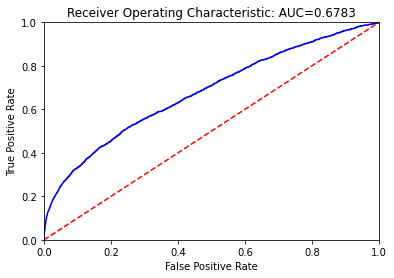

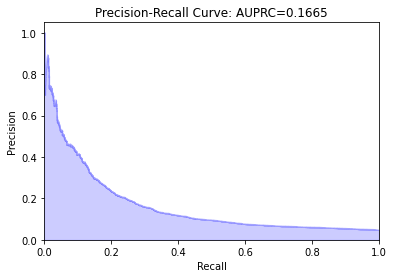

In [12]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 169.51935291290283 seconds
AUC: 0.6878665951359085
AUPRC: 0.1677379102859088
Sensitivity: 0.599548532731377
Specificity: 0.6663090128755365
Score thresold: 0.04589297007858268
2.5 97.5


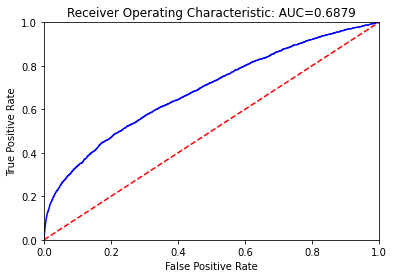

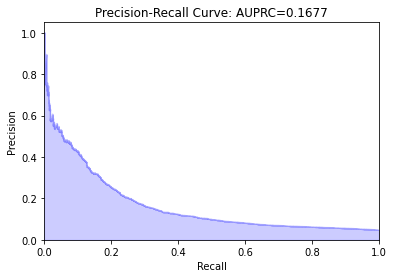

In [13]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


RandomForest:
Training time: 44.53141379356384 seconds
AUC: 0.6635145651075223
AUPRC: 0.1554529280623325
Sensitivity: 0.6058690744920994
Specificity: 0.6270565092989986
Score thresold: 0.05
2.5 97.5


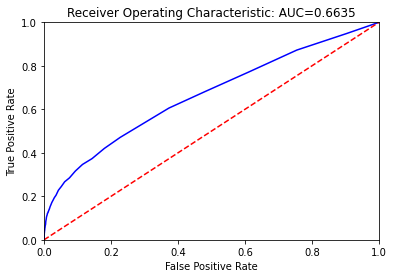

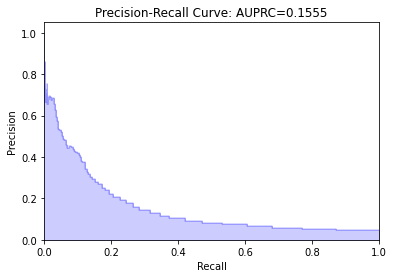

[0.08437864 0.01444174 0.01984269 0.02282803 0.03620274 0.00856039
 0.01282923 0.02016195 0.0010379  0.00211159 0.00421063 0.04356132
 0.02315885 0.00524381 0.00862641 0.00583174 0.00031545 0.0057942
 0.00229645 0.00407414 0.00305763 0.00199993 0.00316426 0.00290543
 0.00283984 0.00266288 0.00281538 0.00133957 0.00599221 0.00196917
 0.00170621 0.00391746 0.00532054 0.0027983  0.00148916 0.00281857
 0.0032403  0.0014903  0.00171436 0.00158534 0.0049097  0.00244574
 0.0023237  0.00284769 0.00637051 0.00466876 0.00367809 0.00107421
 0.00352043 0.00463927 0.00309    0.0053334  0.00137013 0.00365691
 0.00591941 0.00482623 0.00339888 0.00589046 0.06640297 0.07585745
 0.03765236 0.04074882 0.0786396  0.07667513 0.08443145 0.03929635
 0.04999759]


In [14]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier()
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 41.64278721809387 seconds
AUC: 0.695621026853906
AUPRC: 0.1732246759862085
Sensitivity: 0.5873589164785553
Specificity: 0.6903388769670958
Score thresold: 0.04020764428743692
2.5 97.5


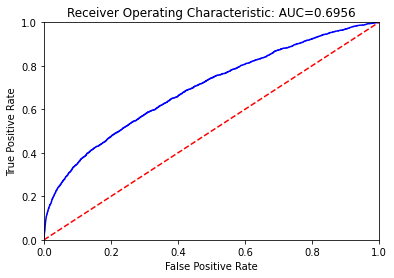

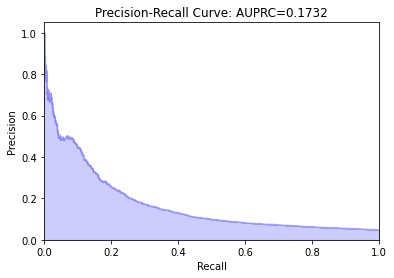

In [15]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [16]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

### 4. Performance output

In [17]:
#result_df = pd.read_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df

,Model,auroc,ap,sensitivity,specificity,threshold,lower_auroc,upper_auroc,std_auroc,lower_ap,upper_ap,std_ap,lower_sensitivity,upper_sensitivity,std_sensitivity,lower_specificity,upper_specificity,std_specificity,runtime
0,LR,0.678253,0.166534,0.568397,0.686449,0.041905,0.665474,0.689144,0.006277,0.149285,0.182099,0.007705,0.544747,0.602108,0.016179,0.655721,0.718638,0.019163,4.352404
1,MLP,0.687867,0.167738,0.599549,0.666309,0.045893,0.675972,0.699725,0.006130,0.151669,0.183278,0.008145,0.573772,0.626240,0.014094,0.644827,0.695715,0.014404,169.519353
2,RF,0.663515,0.155453,0.605869,0.627057,0.050000,0.650535,0.676056,0.006760,0.140168,0.171951,0.007950,0.579802,0.625740,0.012466,0.622822,0.631027,0.009645,44.531414
3,GB,0.695621,0.173225,0.587359,0.690339,0.040208,0.684991,0.708107,0.006090,0.155837,0.188895,0.008042,0.579009,0.660388,0.023561,0.618487,0.698776,0.027229,41.642787


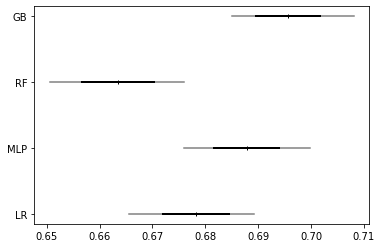

In [18]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval)

In [19]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_72h_ed_revisit_disposition.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
64,ed_los,0.084431
0,age,0.084379
62,ed_sbp_last,0.078640
63,ed_dbp_last,0.076675
59,ed_heartrate_last,0.075857
58,ed_temperature_last,0.066403
66,n_medrecon,0.049998
11,triage_pain,0.043561
61,ed_o2sat_last,0.040749
65,n_med,0.039296
